## Importing packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import lock
from opentnsim import vessel
from opentnsim import import_hydrodynamic_dataset

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

## Creating a network

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(4.432880, 51.699651)}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(4.428526, 51.699461)}
data_node_3 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(4.425455, 51.698741)}
data_node_4 = {"env": [],
               "name": "Node 4",
               "geometry": shapely.geometry.Point(4.421810, 51.697049)}
data_node_5 = {"env": [],
               "name": "Node 5",
               "geometry": shapely.geometry.Point(4.418511, 51.695388)}
data_node_6 = {"env": [],
               "name": "Node 6",
               "geometry": shapely.geometry.Point(4.414839, 51.693438)}
data_node_7 = {"env": [],
               "name": "Node 7",
               "geometry": shapely.geometry.Point(4.411260, 51.691520)}
data_node_8 = {"env": [],
               "name": "Node 8",
               "geometry": shapely.geometry.Point(4.409373, 51.690496)}
data_node_9 = {"env": [],
               "name": "Node 9",
               "geometry": shapely.geometry.Point(4.407558, 51.689505)}
data_node_10 = {"env": [],
               "name": "Node 10",
               "geometry": shapely.geometry.Point(4.403041, 51.687024)}
data_node_11 = {"env": [],
               "name": "Node 11",
               "geometry": shapely.geometry.Point(4.399403, 51.685050)}
data_node_12 = {"env": [],
               "name": "Node 12",
               "geometry": shapely.geometry.Point(4.395440, 51.682944)}
data_node_13 = {"env": [],
               "name": "Node 13",
               "geometry": shapely.geometry.Point(4.390724, 51.680429)}
data_node_14 = {"env": [],
               "name": "Node 14",
               "geometry": shapely.geometry.Point(4.388136, 51.678559)}
data_node_15 = {"env": [],
               "name": "Node 15",
               "geometry": shapely.geometry.Point(4.385356, 51.676018)}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)
node_5 = Node(**data_node_5)
node_6 = Node(**data_node_6)
node_7 = Node(**data_node_7)
node_8 = Node(**data_node_8)
node_9 = Node(**data_node_9)
node_10 = Node(**data_node_10)
node_11 = Node(**data_node_11)
node_12 = Node(**data_node_12)
node_13 = Node(**data_node_13)
node_14 = Node(**data_node_14)
node_15 = Node(**data_node_15)

nodes = [node_1, node_2, node_3, node_4, node_5, node_6, node_7, node_8, node_9, node_10, node_11, node_12, node_13, node_14, node_15]

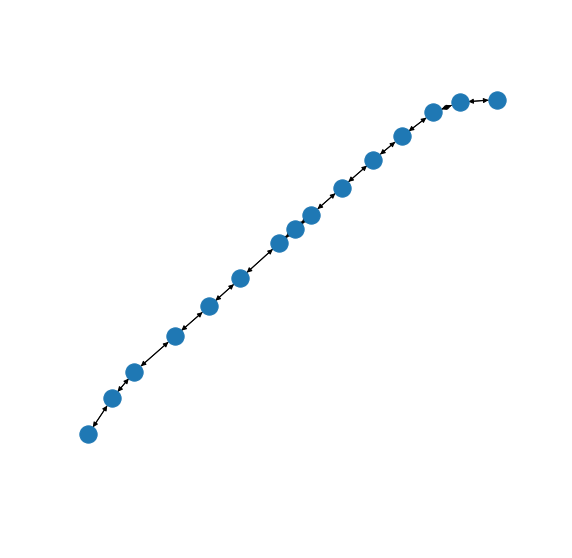

In [3]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2],
        [node_2, node_3],
        [node_3, node_4],
        [node_4, node_5],
        [node_5, node_6],
        [node_6, node_7],
        [node_7, node_8],
        [node_8, node_9],
        [node_9, node_10],
        [node_10, node_11],
        [node_11, node_12],
        [node_12, node_13],
        [node_13, node_14],
        [node_14, node_15],
        [node_15, node_14],
        [node_14, node_13],
        [node_13, node_12],
        [node_12, node_11],
        [node_11, node_10],
        [node_10, node_9],
        [node_9, node_8],
        [node_8, node_7],
        [node_7, node_6],
        [node_6, node_5],
        [node_5, node_4],
        [node_4, node_3],
        [node_3, node_2],
        [node_2, node_1]]

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions,ax=ax)
plt.show()

## Setting up the simulation

In [4]:
# Start simpy environment (at a given date and time)
simulation_start = datetime.datetime.now()
sim = model.Simulation(simulation_start,FG)
env = sim.environment
duration = 5*24*60*60 #seconds

In [5]:
depth = [[],[]]
width = [[],[]]
MBL = [[],[]]
water_level=[[],[]]
salinity =[[],[]]

for nodes in enumerate(FG.nodes):
    MBL[0].append(FG.nodes[nodes[1]]['geometry'])
    width[0].append(FG.nodes[nodes[1]]['geometry'])
    depth[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[1].append([[],[]])
    salinity[0].append((FG.nodes[nodes[1]]['geometry']))
    salinity[1].append([[],[]])

MBL[1] = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
depth[1] = MBL[1]
width[1] = [200,200,200,300,300,300,25,25,25,300,300,200,200,200,200]
times = np.arange(simulation_start.timestamp(),(simulation_start+datetime.timedelta(seconds=duration)).timestamp(),60)

for node in enumerate(list(FG.nodes)):
    if node[0] <= 8:
        water_level[1][node[0]][0]=times
        water_level[1][node[0]][1]=[1.25*np.sin(2*np.pi*(t-simulation_start.timestamp())/45000)+2.5 for t in times]
        salinity[1][node[0]][0]=times
        salinity[1][node[0]][1]=[25 for t in times]
    else:
        water_level[1][node[0]][0]=times
        water_level[1][node[0]][1]=[2.5 for t in times]
        salinity[1][node[0]][0]=times
        salinity[1][node[0]][1]=[0 for t in times]

In [6]:
wlev_dif = [[],[]]
for i in range(len(water_level[1][0][1])):
    wlev_dif[0].append(water_level[1][0][0][i])
    wlev_dif[1].append(abs(water_level[1][10][1][i]-water_level[1][11][1][i]))

In [7]:
import xarray as xr
time_data = xr.DataArray(data=water_level[1][0][0],
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL[1],
                        dims=["NODES"])

width_data = xr.DataArray(data=width[1],
                          dims=["NODES"])

depth_data = xr.DataArray(data=depth[1],
                          dims=["NODES"])

water_level_data = xr.DataArray(data=[wlev[1] for wlev in water_level[1]],
                                dims=["NODES","TIME"])

salinity_data = xr.DataArray(data=[sal[1] for sal in salinity[1]],
                             dims=["NODES","TIME"])

hydrodynamic_data = xr.Dataset({'Times': time_data,
                                'MBL':MBL_data,
                                'Width':width_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

In [8]:
import_hydrodynamic_dataset.NetworkProperties.append_data_to_nodes(FG,hydrodynamic_data)

## Creating two types of vessels

In [9]:
Vessel = type('Vessel', 
              (core.Identifiable, lock.HasLineUpArea, lock.HasWaitingArea, lock.HasLock, core.Movable, core.Routeable, vessel.VesselProperties, vessel.ExtraMetadata), {})
start_point = 'Node 15' 
end_point = 'Node 1'  
data_vessel_one = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                   "geometry": FG.nodes[start_point]['geometry'],
                   "v": 4,
                   "type": 'CEMT - Va',
                   "B": 11.40,
                   "H_e": 7.10, 
                   "H_f": 5.40,
                   "T_e": 1.8,
                   "T_f": 3.5,
                   "L": 135.0,
                   "start_time": 0,}

data_vessel_two = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, end_point, start_point, weight='length'),
                   "geometry": FG.nodes[end_point]['geometry'],
                   "v": 4,
                   "type": 'CEMT - Va',
                   "B": 11.40,
                   "H_e": 7.10, 
                   "H_f": 5.40,
                   "T_e": 1.8,
                   "T_f": 3.5,
                   "L": 135.0,
                   "start_time": 0,}

## Adding the generator to the simulation

In [10]:
env.FG = FG
vessels = []
for i in range(4):
    vessel = Vessel(**data_vessel_one)
    sim.add_vessels(start_point,end_point,[],vessel)
    
    vessel = Vessel(**data_vessel_two)
    sim.add_vessels(end_point,start_point,[],vessel)

## Defining the infrastructure of the lock

In [11]:
waiting_area_1 = lock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen', node = "Node 4")

lineup_area_1 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = 'Volkeraksluizen_1', node = "Node 6", lineup_length = 300)

lineup_area_2 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = 'Volkeraksluizen_2', node = "Node 6", lineup_length = 300)

lineup_area_3 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = 'Volkeraksluizen_3', node = "Node 6", lineup_length = 300)

lock_1 = lock.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                         node_1 = "Node 7", node_2 = "Node 8", node_3 = "Node 9",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                         doors_open = 10 * 60, doors_close = 10 * 60, disch_coeff = 0.8,
                         grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                         simulation_start = simulation_start)

lock_2 = lock.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_2',            
                         node_1 = "Node 7", node_2 = "Node 8", node_3 = "Node 9",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                         doors_open = 10 * 60, doors_close = 10 * 60, disch_coeff = 0.8,
                         grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                         simulation_start = simulation_start)

lock_3 = lock.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_3',            
                         node_1 = "Node 7", node_2 = "Node 8", node_3 = "Node 9",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                         doors_open = 10 * 60, doors_close = 10 * 60, disch_coeff = 0.8,
                         grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                         simulation_start = simulation_start)

lineup_area_4 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = "Volkeraksluizen_1", node = "Node 10", lineup_length = 300)

lineup_area_5 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = "Volkeraksluizen_2", node = "Node 10", lineup_length = 300)

lineup_area_6 = lock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = "Volkeraksluizen_3", node = "Node 10", lineup_length = 300)

waiting_area_2 = lock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = "Volkeraksluizen", node = "Node 12")

## Appending the infrastructure to the network

In [12]:
#For testing, all locks have the water level at the right side
lock_1.water_level = "Node 7"
lock_2.water_level = "Node 9"
lock_3.water_level = "Node 7"
FG.nodes["Node 8"]["Lock"] = [lock_1, lock_2, lock_3]

FG.nodes["Node 6"]["Line-up area"] = [lineup_area_1,lineup_area_2,lineup_area_3]
FG.nodes["Node 10"]["Line-up area"] = [lineup_area_4,lineup_area_5,lineup_area_6] 

FG.nodes["Node 4"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 12"]["Waiting area"] = [waiting_area_2]

## Run the simulation

In [13]:
env.FG = FG
t0 = timepy.time()
sim.run(duration = duration) # this statement runs the simulation
t1 = timepy.time()
total = t1-t0
print(total) #simulation time in seconds

c:\users\floorbakker\opentnsim\opentnsim\lock.py:314: RuntimeWarning:

invalid value encountered in sqrt

c:\users\floorbakker\opentnsim\opentnsim\lock.py:315: RuntimeWarning:

invalid value encountered in sqrt

c:\users\floorbakker\opentnsim\opentnsim\lock.py:172: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\floorbakker\opentnsim\opentnsim\lock.py:268: RuntimeWarning:

divide by zero encountered in double_scalars



0.378342866897583


## Output

In [14]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

In [15]:
df = pd.DataFrame.from_dict(vessels[0].log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 15 to node Node 14 start,2022-08-17 17:03:41.000000,[],POINT (4.385356 51.676018)
1,Sailing from node Node 15 to node Node 14 stop,2022-08-17 17:05:06.478390,[],POINT (4.388136 51.678559)
2,Sailing from node Node 14 to node Node 13 start,2022-08-17 17:05:06.478390,[],POINT (4.388136 51.678559)
3,Sailing from node Node 14 to node Node 13 stop,2022-08-17 17:06:15.094729,[],POINT (4.390724 51.680429)
4,Sailing from node Node 13 to node Node 12 start,2022-08-17 17:06:15.094729,[],POINT (4.390724 51.680429)
5,Sailing from node Node 13 to node Node 12 stop,2022-08-17 17:08:02.534345,[],POINT (4.39544 51.682944)
6,Sailing from node Node 12 to node Node 11 start,2022-08-17 17:08:02.534345,[],POINT (4.39544 51.682944)
7,Sailing from node Node 12 to node Node 11 stop,2022-08-17 17:11:02.829781,[],POINT (4.399403 51.68505)
8,Sailing from node Node 11 to node Node 10 start,2022-08-17 17:11:02.829781,[],POINT (4.399403 51.68505)
9,Sailing from node Node 11 to node Node 10 stop,2022-08-17 17:15:46.064447,[],POINT (4.405560257200228 51.68840777807449)


In [16]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].route[0] == 'Node 1':
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir1 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir1:
                    pass
                else:
                    locking_cycle_start_dir1 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir1.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir1 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir1 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir1 and vessels[v2].route[0] == 'Node 1':                               
                                    if len(locking_cycle_starts_dir1) != len(locking_cycle_stops_dir1):
                                        locking_cycle_stops_dir1.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir1[-1][0]:
                                        locking_cycle_stops_dir1[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

        elif vessels[v].route[0] == 'Node 15': 
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir2 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir2:
                    pass
                else:
                    locking_cycle_start_dir2 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir2.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir2 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir2 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir2 and vessels[v2].route[0] == 'Node 15':                               
                                    if len(locking_cycle_starts_dir2) != len(locking_cycle_stops_dir2):
                                        locking_cycle_stops_dir2.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir2[-1][0]:
                                        locking_cycle_stops_dir2[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

inoperation_time_doors1 = locking_cycle_starts_dir2+locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1+locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if i != 0 and inoperation_time_doors1[i][1] == 'Start' and inoperation_time_doors1[i-1][1] != 'Start':
        loop_time_doors1.append((inoperation_time_doors1[i][0]-inoperation_time_doors1[i-1][0])/60)
        
for i in range(len(inoperation_time_doors2)):
    if i != 0 and inoperation_time_doors2[i][1] == 'Start' and inoperation_time_doors2[i-1][1] != 'Start':
        loop_time_doors2.append((inoperation_time_doors2[i][0]-inoperation_time_doors2[i-1][0])/60)

In [17]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].log["Value"][t]/60)
            
for v in range(len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

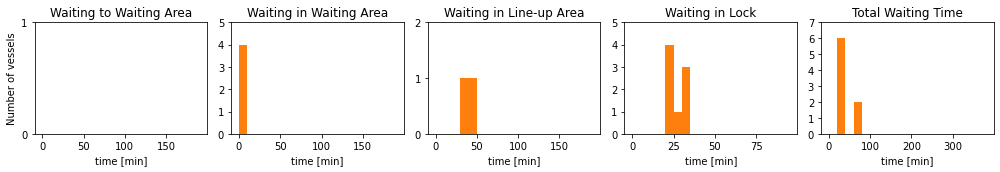

In [18]:
data= [waiting_to_waiting_area,waiting_in_waiting_area,waiting_in_lineup_area,waiting_in_lock,total_waiting_time]
xaxes = 'time [min]'
titles = ['Waiting to Waiting Area','Waiting in Waiting Area','Waiting in Line-up Area','Waiting in Lock','Total Waiting Time'] 
bins = [range(0,200,10),range(0,200,10),range(0,200,10),range(0,100,5),range(0,400,20)]

f,a = plt.subplots(1,5,figsize=(14, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Number of vessels')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

In [19]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []
origin = 'Node 1'
destination = 'Node 15'

for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 15':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance((env.FG.nodes[destination]['geometry'].x,env.FG.nodes[destination]['geometry'].y),(env.FG.nodes[origin]['geometry'].x,env.FG.nodes[origin]['geometry'].y))-
                                  calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

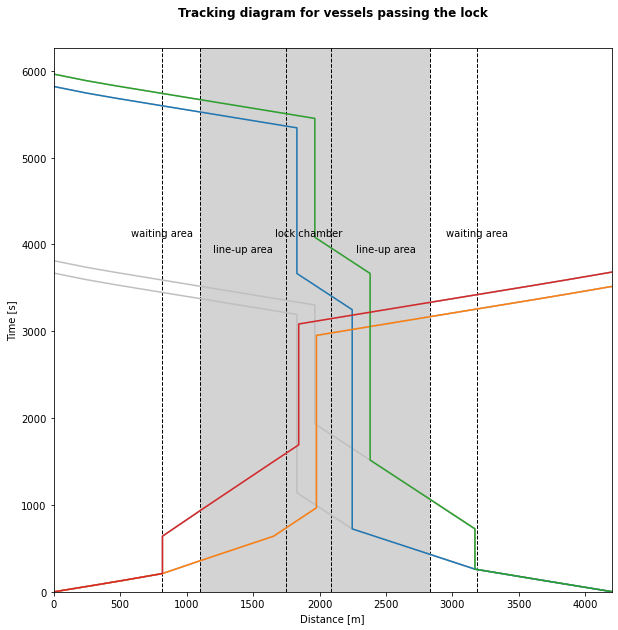

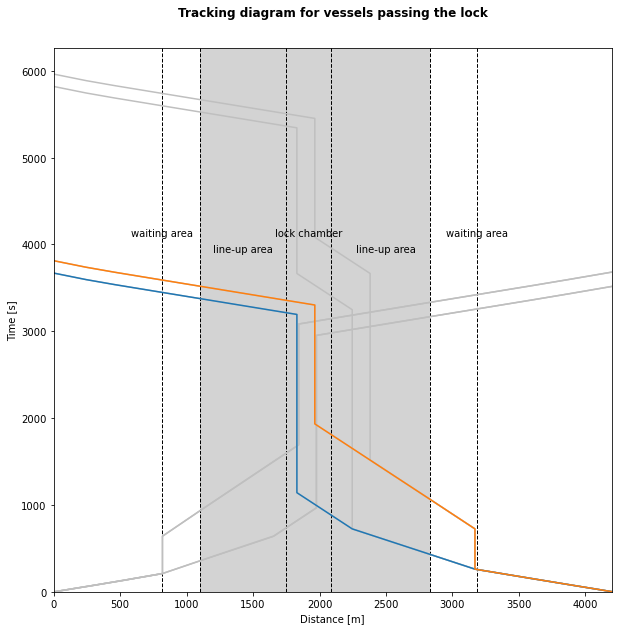

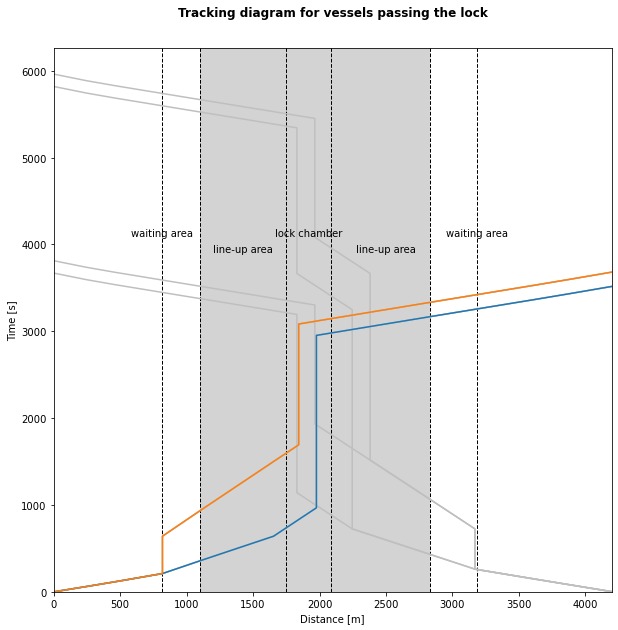

In [20]:
for p in range(0,len(FG.nodes['Node 8']['Lock'])):
    fig, ax = plt.subplots(figsize=(10, 10))
    vessel_path_x0 = (FG.nodes['Node 1']['geometry'].x,FG.nodes['Node 1']['geometry'].y)

    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)
    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)
    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)
    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)
    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)
    plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y,
                                                     FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                     color = 'k', linestyle = '--', linewidth = 1.0)  
    for v in reversed(range(0,len(vessels))):
        plt.plot(vessel_path_x[v],vessel_path_t[v],color='0.75')
    for v in range(0,len(vessels)):
        if vessels[v].lock_name == FG.nodes['Node 8']['Lock'][p].name:
            plt.plot(vessel_path_x[v],vessel_path_t[v])

    plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),1.075*max(max(vessel_path_t)),'lock chamber',horizontalalignment = 'center')
    plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),1.025*max(max(vessel_path_t)),'line-up area',horizontalalignment = 'center')
    plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),1.025*max(max(vessel_path_t)),'line-up area',horizontalalignment = 'center')
    plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),1.075*max(max(vessel_path_t)),'waiting area',horizontalalignment = 'center')
    plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),1.075*max(max(vessel_path_t)),'waiting area',horizontalalignment = 'center')

    plt.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
    plt.xlabel("Distance [m]")
    plt.xlim([0,0.95*ax.get_xlim()[1]])
    plt.ylim([0,ax.get_ylim()[1]])
    plt.ylabel("Time [s]")

    plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
             [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

    plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
             [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

    plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y))],
             [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.show()

In [21]:
df = pd.DataFrame.from_dict(lock_1.log)
df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2022-08-17 17:31:53.651239,2,Node 7
1,Lock doors closing stop,2022-08-17 17:41:53.651239,2,Node 7
2,Lock chamber converting start,2022-08-17 17:41:53.651239,2,Node 7
3,Lock chamber converting stop,2022-08-17 17:42:53.651239,2,Node 9
4,Lock doors opening start,2022-08-17 17:42:53.651239,2,Node 9
5,Lock doors opening stop,2022-08-17 17:52:53.651239,2,Node 9
6,Lock doors closing start,2022-08-17 18:11:43.444644,2,Node 9
7,Lock doors closing stop,2022-08-17 18:21:43.444644,2,Node 9
8,Lock chamber converting start,2022-08-17 18:21:43.444644,2,Node 9
9,Lock chamber converting stop,2022-08-17 18:22:43.444644,2,Node 7


In [22]:
door_open_time_doors_1 = []
door_open_time_doors_2 = []
end_time = []
for v in range(0,len(vessels)):
    end_time.append(vessels[v].log["Timestamp"][-1].timestamp())
end_of_simulation = max(end_time)

for l in range(0,len(env.FG.nodes['Node 8']['Lock'])):
    for t in range(0,len(env.FG.nodes['Node 8']['Lock'][l].log["Message"])-1):
        if env.FG.nodes['Node 8']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 8']['Lock'][l].log["Geometry"][t] == 'Node 7':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 8']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_1.append(env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_1.append(env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)
        elif env.FG.nodes['Node 8']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 8']['Lock'][l].log["Geometry"][t] == 'Node 9':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 8']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_2.append(env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_2.append(env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)

for l in range(0,len(env.FG.nodes['Node 8']['Lock'])):
    for t in reversed(range(0,len(env.FG.nodes['Node 8']['Lock'][l].log["Message"]))):
        if env.FG.nodes['Node 8']['Lock'][l].log["Message"][t] == "Lock doors opening stop" and env.FG.nodes['Node 8']['Lock'][l].log["Geometry"][t] == 'Node 7':          
            for t2 in range(t,len(env.FG.nodes['Node 8']['Lock'][l].log["Message"])):
                if env.FG.nodes['Node 8']['Lock'][l].log["Message"][t2] == "Lock doors closing stop":
                    pass
            else:
                door_open_time_doors_1.append(end_of_simulation/60-
                                              env.FG.nodes['Node 8']['Lock'][l].log["Timestamp"][t].timestamp()/60)
                break


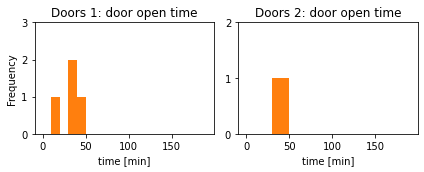

In [23]:
data= [door_open_time_doors_1,door_open_time_doors_2]
xaxes = 'time [min]'
titles = ['Doors 1: door open time','Doors 2: door open time'] 
bins = [range(0,200,10),range(0,200,10)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

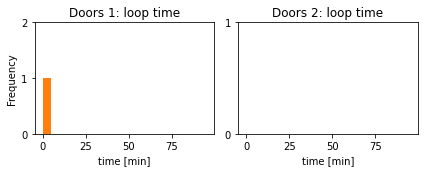

In [24]:
data= [loop_time_doors1,loop_time_doors2]
xaxes = 'time [min]'
titles = ['Doors 1: loop time','Doors 2: loop time'] 
bins = [range(0,100,5),range(0,100,5)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()